# CAP 6618 - Machine Learning for Computer Vision

## Programming Project 1
See guidelines on Canvas for details.

# Step 1: Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"

def save_fig(fig_id, tight_layout=True):
    image_dir = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
    if not os.path.exists(image_dir):
        os.makedirs(image_dir)

    path = os.path.join(image_dir, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# Step 2: Load the MNIST dataset

**Warning**: `fetch_mldata()` is deprecated since Scikit-Learn 0.20. You should use `fetch_openml()` instead. However, it returns the unsorted MNIST dataset, whereas `fetch_mldata()` returned the dataset sorted by target (the training set and the test test were sorted separately). In general, this is fine, but if you want to get the exact same results as before, you need to sort the dataset using the following function:

In [2]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

In [3]:
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, cache=True)
    mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
    sort_by_target(mnist) # fetch_openml() returns an unsorted dataset
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')
mnist["data"], mnist["target"]

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0, 0, 0, ..., 9, 9, 9], dtype=int8))

In [4]:
X, y = mnist["data"], mnist["target"]

# Step 3: Visualize (and play with) the MNIST dataset

In [5]:
X.shape

(70000, 784)

In [6]:
y.shape

(70000,)

Saving figure some_digit_plot


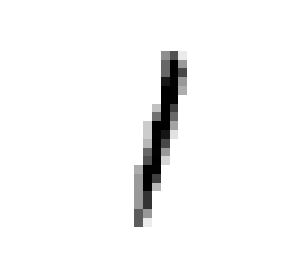

In [7]:
#select and display some digit from the dataset
import matplotlib
import matplotlib.pyplot as plt

some_digit_index = 7201
some_digit = X[some_digit_index]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
           interpolation="nearest")
plt.axis("off")

save_fig("some_digit_plot")
plt.show()

In [8]:
#print some digit's label
print('The ground truth label for the digit above is: ',y[some_digit_index])

The ground truth label for the digit above is:  1


#### Assignment question 4a

Check if the data set is well balanced, i.e. the classes are similarly represented.

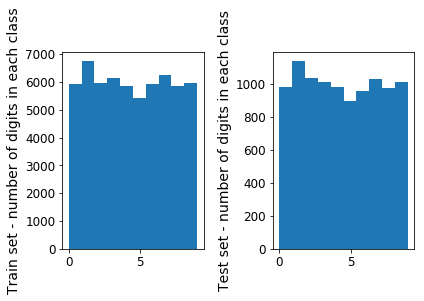

In [51]:
plt.figure()
plt.subplot(121); plt.hist(y_train); plt.ylabel('Train set - number of digits in each class')
plt.subplot(122); plt.hist(y_test); plt.ylabel('Test set - number of digits in each class')
plt.tight_layout()
plt.show()

# Step 4: Split the dataset

In [9]:
#Split dataset
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

#### Assignment question 4b

Stratified shuffling vs. random permutation: since the train and test datasets are large and balanced, with similar frequency for all classes, random permutation is enough in this case. Stratified sample would make a difference in imbalaced datasets.

In [10]:
#random shuffle
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

# Step 5: Classification using "Built-in classifier 1" and default parameters 

#### Assignment question 4c

This step uses a stochastic gradient descent classifier, i.e. it uses the gradient descent algorithm to optimize a loss function. At each step it will attempt to reduce the error (as defined by the loss function) by moving in the opposite direction of the gradient.

These are the most important parameters that affect this classifier:

1. Regularization/penalty: changes how the classifier generalizes (reduces overifiting). The first parameter to play with if the clasissifier performs well in training/validation, but performs badly in testing/prediction.
1. Learning rate: affects the speed of the convergence, or in some cases, if the classifier converges at all. It can be a defined value or an adaptive rate, one that will change when the classifier is not improving.
1. The number of iterations: how many times the classifier will go over the training data. Prevents the classifier from spending lots of computing resources without commensurable improvements in results.

Other parameters that may be of interest are:

1. The loss function: most of the time the standard RMSE (root mean square error) will be enough, but for some datasets other loss functions may be more useful.
1. The regularization/penalty constant: adjusts how sensitive the classifier is to the regularization terms. Most of the time the small default value is enough, but it may need to be increased in case of severe overfitting.
1. Early stopping: stops the optimization process if the classifier is not improving after a certain number of iterations. It is particularly useful for computation-intensive classifiers.


In [11]:
%%time

from sklearn.linear_model import SGDClassifier

#build and fit linear model
# "Under the hood, Scikit-Learn actually trained 10 binary classifiers, got their decision
# scores for the image, and selected the class with the highest score"
sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state=42)
fit_results = sgd_clf.fit(X_train, y_train)
print(fit_results) # need to explicitly print results because of %%time

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=-inf,
       validation_fraction=0.1, verbose=0, warm_start=False)
CPU times: user 4.02 s, sys: 23.4 ms, total: 4.05 s
Wall time: 4.1 s


In [12]:
#test model by making a prediction on some_digit
sgd_clf.predict([some_digit])

array([1], dtype=int8)

In [13]:
#inspect decision function
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-660561.16495471,  169164.71870837, -144815.5052832 ,
         -69500.1526722 , -172916.94934103, -248951.73204392,
        -280541.23990047,  -72041.70140166, -173346.54197882,
           2718.11617764]])

In [14]:
#select (the index of the) max value among scores
np.argmax(some_digit_scores)

1

#### Assignment question 4d

Cross-validation score parameters:
    
1. The classifier to be evaluated.
1. The training dataset.
1. The training labels (matching the training dataset samples).
1. The number of folds to use for splitting. It will fit (train) the classifier in n-1 of the folds and validation (test) on the remaining folder. This is repeated for all combination of training and validation folders.
1. The metric ("scoring") to apply to the classifier. Since we are working with a multilabel classification problem on a well-balanced dataset, "accuracy" is an adequate metric.

In [15]:
from sklearn.model_selection import cross_val_score

# Performs k-fold (3, in this case) cross-validation: train with k-1 folds, validate on the remaining fold
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.84063187, 0.84899245, 0.86652998])

In [16]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

# Confusion matrix reminder:
#  - Rows = actual class
#  - Columns = predicted class

array([[5604,    2,   81,   25,    8,   44,   32,    9,  115,    3],
       [   1, 6292,   72,   54,   20,   22,    8,    8,  262,    3],
       [  59,   73, 5016,  218,   68,   25,   82,   58,  344,   15],
       [  40,   16,  148, 5315,   19,  199,   23,   41,  297,   33],
       [  24,   26,  145,   39, 4746,   22,   63,   49,  502,  226],
       [  73,   25,   74,  375,   62, 3868,   91,   22,  771,   60],
       [  50,   19,  128,   13,   84,  105, 5369,    8,  140,    2],
       [  65,   19,   69,  117,  100,   18,    2, 5641,  112,  122],
       [  47,   96,  127,  196,   77,  135,   30,   23, 5088,   32],
       [  58,   45,   59,  199,  233,   59,    2,  385,  725, 4184]])

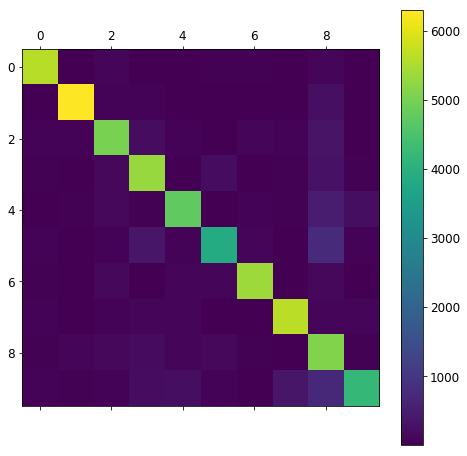

In [17]:
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)
plot_confusion_matrix(conf_mx)

Saving figure confusion_matrix_plot


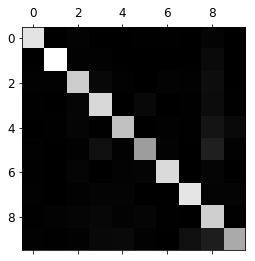

In [18]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_plot", tight_layout=False)
plt.show()

# What this plot shows:
#    - Most of the images are in the diagonal = classified correctly
#    - 5s look slightly darker = either few 5s or classifier performs worse on them
#
# NOTE: this may change in future runs - review after executing code again

In [19]:
# Normalize the values to compare error rates, not absolute number (penalizes classes with more instances)
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

Saving figure confusion_matrix_errors_plot


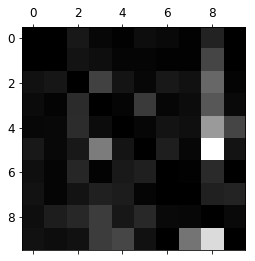

In [20]:
# Fill the diagonal with zero to keep only errors
np.fill_diagonal(norm_conf_mx, 0)

plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_errors_plot", tight_layout=False)
plt.show()

# What this plot shows:
#    - Column for 8 is bright = many 8s misclassified
#         Bright spot for row 5: several 5s misclassified as 8s
#    - Column for 0, 1, 6, 7 are dark = most classified correctly
#
# There is also a bright spot in the intersection of column 8 with
# row 9, indicating that 9s are being classified as 8. Similarly for
# row 4, column 8. Not as bad as 5 vs. 8, but still bright.
#
# NOTE: this may change in future runs - review after executing code again

In [21]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

Saving figure error_analysis_digits_plot


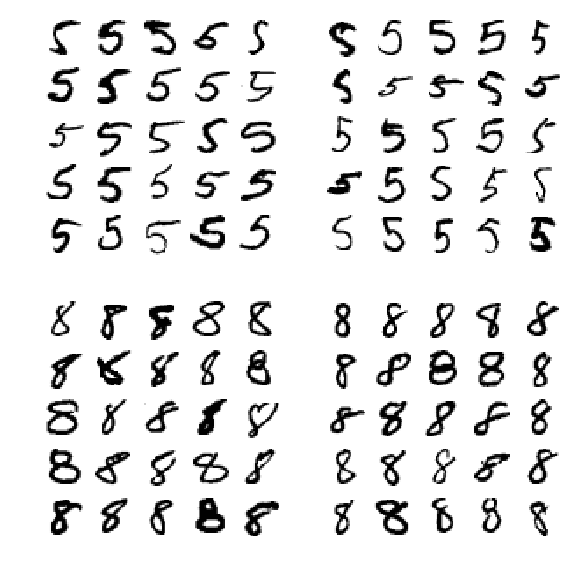

In [22]:
# Plot high misclassifications to analyze them

# Largest errors - adjust if previous cells shows different errors
cl_a, cl_b = 5, 8

# Class a - correctly classified as a
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
# Class a - incorrectly classified as b
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
# Class b - incorrectly classified as a
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
# Class b - correctly classified as b
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
save_fig("error_analysis_digits_plot")
plt.show()

# Plot arrangement

#  X_aa  X_ab
#  X_ba  X_bb

#  actual A classified as A     actual A classified as B
#  actual B classified as A     actual B classified as B

# Simplifying:
#  Left column:     Right column:
#    classified A     classified B


### Analysis based on the book

These are obvious errors. Why is the classifier making them?

1. The classifier we are using, `SGDClassifier`, is a linear classifier.
1. As such, it assigns a weight per class for each pixel. 
1. When it sees a new image, it sums up the weighted pixel intensities to get a score for each class.
1. Numbers that differ only by a few pixels have a higher risk of being misclassified


In [23]:
# Evaluate accuracy on test set
from sklearn.metrics import accuracy_score
y_pred = sgd_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.8613

# Step 6: Classification using "Built-in classifier 2" and default parameters 

#### Assignment question 4e

This section uses a `RandomForestClassifier`. It is a set of decision tree classifiers, combined into one output by averaging the output of each decision tree.

Parameters that significantly affect this classifier are:

1. Number of estimators: the number of trees in the estimator. Too few of them may result in low variance, but high bias (underfitting). Too many of them may increase variance, but reduce bias (overfitting).
1. The maximum depth can help choose between variance and bias.

In [24]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=10, random_state=42)
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([1], dtype=int8)

In [25]:
forest_clf.predict_proba([some_digit])

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [26]:
cross_val_score(forest_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.94041192, 0.93879694, 0.93949092])

In [27]:
y_train_pred = cross_val_predict(forest_clf, X_train, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5804,    1,   11,    9,    8,   14,   32,    3,   38,    3],
       [   1, 6616,   39,   23,   13,    6,    9,   19,   10,    6],
       [  48,   31, 5633,   50,   49,   16,   27,   41,   54,    9],
       [  20,   17,  137, 5645,   16,  124,    7,   45,   88,   32],
       [  18,   17,   33,   11, 5526,    4,   35,   19,   26,  153],
       [  52,   21,   27,  202,   39, 4938,   43,    6,   62,   31],
       [  56,   17,   21,    9,   27,   66, 5695,    0,   23,    4],
       [  12,   38,   96,   26,   69,   10,    1, 5912,   15,   86],
       [  28,   60,   99,  153,   59,   98,   33,   15, 5229,   77],
       [  33,   18,   24,   98,  164,   44,   10,  114,   68, 5376]])

Saving figure confusion_matrix_plot


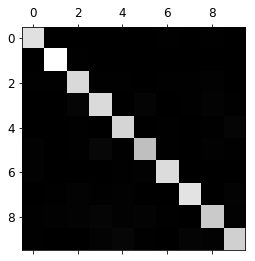

In [28]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_plot", tight_layout=False)
plt.show()

In [29]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

Saving figure confusion_matrix_errors_plot


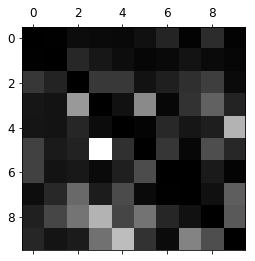

In [30]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_errors_plot", tight_layout=False)
plt.show()

Saving figure error_analysis_digits_plot


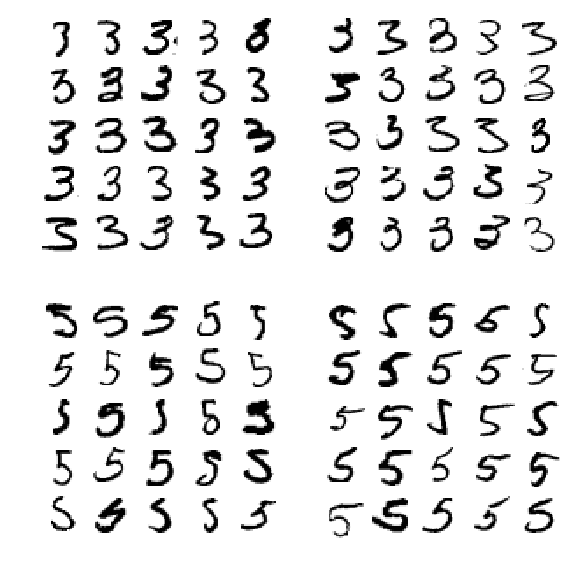

In [31]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
save_fig("error_analysis_digits_plot")
plt.show()

In [32]:
#Evaluate accuracy on test set
y_pred = forest_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9472

# Step 7: Investigate the impact of data normalization / standardization

#### Assignment question 4f

This code scales the training set and trains the classifier on that data.

It allows us to compare the results of the classifier before we scale the training data (cells above) and after we scale it.

#### Assignment question 4g

Scaling the training data or not affects some classifiers and does not affect others.

Classifiers that calculate formulas that use the actual feature data (the actual value of each feature) are affected by scaling because some features (usually the ones with high values) can dominate features with smaller values. This may unduly give more weight to a feature simply because it has a higher absolute value.

Some classifiers are not affected by scaling. These are the ones that do not perform calculations using the feature values.

Random forester is one such classifier. It's not affect much by scaling. In this case in paticular, scaling the features reduced overall accuracy.

In [33]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.91011798, 0.90874544, 0.906636  ])

In [34]:
y_train_pred = cross_val_predict(forest_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5805,    1,   11,    9,    8,   13,   32,    3,   38,    3],
       [   1, 6616,   39,   23,   13,    6,    9,   19,   10,    6],
       [  49,   30, 5638,   49,   47,   16,   28,   41,   53,    7],
       [  20,   17,  135, 5646,   16,  123,    7,   45,   90,   32],
       [  18,   17,   33,   11, 5526,    4,   35,   19,   26,  153],
       [  52,   21,   27,  201,   40, 4939,   43,    6,   62,   30],
       [  56,   17,   21,    9,   27,   68, 5692,    0,   24,    4],
       [  12,   39,   97,   26,   69,    9,    1, 5911,   15,   86],
       [  29,   60,   98,  153,   57,  100,   33,   15, 5229,   77],
       [  34,   18,   23,   98,  164,   45,   10,  115,   68, 5374]])

Saving figure confusion_matrix_plot


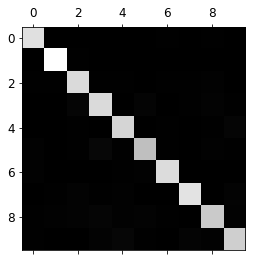

In [35]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_plot", tight_layout=False)
plt.show()

In [36]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

Saving figure confusion_matrix_errors_plot


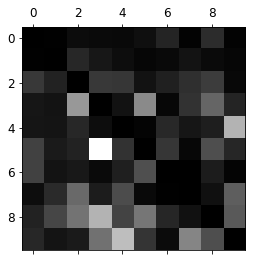

In [37]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_errors_plot", tight_layout=False)
plt.show()

Saving figure error_analysis_digits_plot


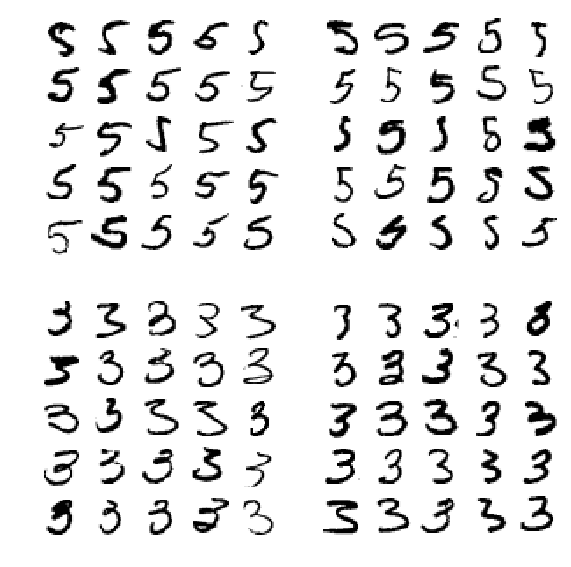

In [38]:
cl_a, cl_b = 5, 3
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
save_fig("error_analysis_digits_plot")
plt.show()

In [39]:
#Evaluate accuracy on test set
X_test_scaled = scaler.fit_transform(X_test.astype(np.float64))
y_pred = forest_clf.predict(X_test_scaled)
accuracy_score(y_test, y_pred)

0.2983

#### Assignment question 4g

The cell above is performing prediction on the scaled data. This is incorrect. We want to verify the behavior of the classifier on the actual value of the samples, as they would be presented to the classifier in real life.

In [40]:
#Evaluate accuracy on test set
y_pred = forest_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9472

# Step 8: Build, train, and evaluate a third classifier

Make results of this section predictable across runs. Not all classifiers accept a `random_state` parameter.

In [41]:
np.random.seed(42)

Try several classifiers to pick to work with.

Uncomment one of the classifiers below at a time.

In [42]:
%%time

# Use a generic name for the classifier (step8_clf) so we can update it without changing the rest of the code

# All times reported below are on a MacBook 2017 i7 2.9 GHz
# Training times are from .fit() and accuracy and test time are from cross_val_score()
# All times and percentages are approximate

# Fast training time 20s, good accuracy 97%, long test time 54min
# Training time is fast because it's not really "training" - calculations happen at test time
# Using n_jobs=-1 to parallelize reduces test time to 12min
# from sklearn.neighbors import KNeighborsClassifier
# #step8_clf = KNeighborsClassifier(n_neighbors=3) # uses only one CPU (54min)
# step8_clf = KNeighborsClassifier(n_neighbors=3, n_jobs=-1) # parallelize as much as possible (12min)

# Really, really slow training time 5h+, accuracy is low 17%, looong test time 5h+
# Needs some serious dimensionality reduction to be useful
# from sklearn.svm import SVC
# step8_clf = SVC(gamma="scale") # defaults to RBF kernel

# Fast training time 2min, low accuracy 73%, test time 2min
# Perhaps could be tuned to improve accuracy
# from sklearn.ensemble import AdaBoostClassifier
# step8_clf = AdaBoostClassifier()

# Super fast training time 2s, terrible accuracy 55%, test time 5s
# Doesn't seem to have any tunable hyperparameter that would help improve it
from sklearn.naive_bayes import GaussianNB
step8_clf = GaussianNB()

# Slow training time 29min, accuracy is OK, but not great 93%, test time 54min
# from xgboost import XGBClassifier
# #step8_clf = XGBClassifier()
# Increasing number of jobs reduces training time to 26min and test time to 52min (not much)
# step8_clf = XGBClassifier(n_jobs=4) # parallelized (4 = number of cores in this machine)

# Takes 2mn to train, but ends with "failed to converge" message, test time is 5min and accuracy is 87%
# from sklearn.svm import LinearSVC
# step8_clf = LinearSVC()
# # Setting max_iter=100000 takes about 2h of training and 3h of test time, with accuracy 82%
# #step8_clf = LinearSVC(max_iter=100000)

# Train the classifier
fit_results = step8_clf.fit(X_train, y_train)
print(fit_results) # need to explicitly print results because of %%time

GaussianNB(priors=None, var_smoothing=1e-09)
CPU times: user 569 ms, sys: 232 ms, total: 801 ms
Wall time: 806 ms


In [43]:
%%time

#test model by making a prediction on some_digit
step8_clf.predict([some_digit])

CPU times: user 1.89 ms, sys: 1.28 ms, total: 3.16 ms
Wall time: 1.95 ms


array([1], dtype=int8)

In [44]:
# Check how sure the classifier is
# Since we are playing with classifiers in this section, check what the classifier supports first
# Code is courtesy of https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html
if hasattr(step8_clf, "decision_function"):
    print("Using decision function")
    some_digit_scores = step8_clf.decision_function([some_digit])
else:
    print("Using prediction probability")
    some_digit_scores = step8_clf.predict_proba([some_digit])
print(some_digit_scores)

Using prediction probability
[[0.00000000e+000 1.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000 0.00000000e+000 3.21543517e-310
  2.34970768e-245 8.74068225e-172]]


In [45]:
#select (the index of the) max value among scores
# TODO: this code may fail if we fall into the "decision_function" branch above - test and fix
np.argmax(some_digit_scores)

1

In [50]:
%%time
from sklearn.model_selection import cross_val_score

# Performs k-fold (3, in this case) cross-validation: train with k-1 folds, validate on the remaining fold
scores = cross_val_score(step8_clf, X_train, y_train, cv=3, scoring="accuracy")
print(scores)

[0.56158768 0.55517776 0.55993399]
CPU times: user 3.87 s, sys: 1.53 s, total: 5.4 s
Wall time: 5.44 s


In [47]:
%%time

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(step8_clf, X_train, y_train, cv=3, n_jobs=-1)
conf_mx = confusion_matrix(y_train, y_train_pred)
print(conf_mx)

# Confusion matrix reminder:
#  - Rows = actual class
#  - Columns = predicted class

[[5315   12   36   21    9   17  156    5  259   93]
 [   4 6371   15   35    2   11   77    4  149   74]
 [ 638  187 1679  493   31   47 1442   16 1338   87]
 [ 459  353   49 2266   16   12  272   52 2036  616]
 [ 180   65   49   32  988   36  504   25 1227 2736]
 [ 710  164   34  123   34  330  269   12 3203  542]
 [  71  139   32    7    6   27 5512    0  116    8]
 [  30   51    8   59   59   14   15 1920  194 3915]
 [ 118  907   25   52   22   45   96    7 3567 1012]
 [  34   62   18    7   39    5    5   88  105 5586]]
CPU times: user 172 ms, sys: 193 ms, total: 365 ms
Wall time: 4.11 s


Saving figure confusion_matrix_plot


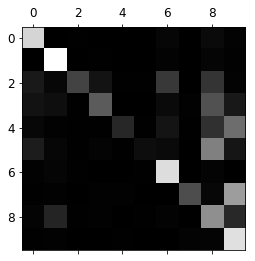

In [48]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_plot", tight_layout=False)
plt.show()

# What this plot shows:
#    - Most of the images are in the diagonal = classified correctly
#    - Darker spots = either few samples for that digit or classifier performs worse on them

# Step 9: Perform hyperparameter optimization (if applicable)

Refer to final notebook.

# Step 10: Build your best solution (and explain each step) 

## Use a separate notebook